# Summary
Available techniques supported to some blocks/layers for doing dynamic and static quantization

|Layers|Static Quantization|Dynamic Quantization|
|-|-|-|
|nn.Linear|Y|Y|
|nn.Conv1d/2d/3d|Y|N|
|nn.LSTM|N|Y|
|nn.GRU|N|Y|
|nn.RNNCell|N|Y|
|nn.GRUCell|N|Y|
|nn.LSTMCell|N|Y|
|nn.EmbeddingBag|Y (activations are in fp32)|N|
|nn.Embedding|Y|Y|
|nn.MultiheadAttention|Not supported|Not supported|
|Activations|Broadly supported|Un-changed, computations stay in fp32|

# Homework
จงบีบอัดแบบ quantization ไปยัง VGG16 (Referred to W4-2) โดยให้เทียบวิธีการ

*   Dynamic quantization (PTDQ)
*   Static quantization (PTSQ)
*   Quantization-Aware Training (QAT)


กำหนดให้การทำ Finetune ของ QAT ทำให้มีผลประสิทธิภาพน้อยกว่าเดิมเล็กน้อยหรือใกล้เคียงกับก่อนทำ Quantized ให้ได้มากที่สุด (Best case: < -1 %) \
จัดส่งเป็น PDF ที่เปรียบเทียบผลตามวิธีการข้างต้น วัดผลในเชิง

*   Quantitative results (acc., loss, etc.)
*   Computational resource in use (training time, parameters, FLOPs, etc.)


In [2]:
!conda install -y gdown

Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - nodefaults
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.8.30  |       hbcca054_0         155 KB  conda-forge
    certifi-2024.8.30          |     pyhd8ed1ab_0         160 KB  conda-forge
    filelock-3.16.1            |     pyhd8ed1ab_0          17 KB  conda-forge
    gdown-5.2.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    libgcc-14.1.0              |       h77fa898_1         827 KB  conda-forge
    libgcc-ng-14.1.0           |       h69a702a_1          51 KB  conda-forge
    libgomp-14.1.0             |       h77fa898_1         449 KB  conda-forge
    libstdcxx-14.1.0           |       hc0a3c3

In [3]:
import gdown 
url = 'https://drive.google.com/uc?id=1iSJLa5k_DKilPlrCTjCCVJWhPAJHmcn3'
filename = 'MNIST_DATASET.zip'
gdown.download(url, filename)

Downloading...
From (original): https://drive.google.com/uc?id=1iSJLa5k_DKilPlrCTjCCVJWhPAJHmcn3
From (redirected): https://drive.google.com/uc?id=1iSJLa5k_DKilPlrCTjCCVJWhPAJHmcn3&confirm=t&uuid=59356d3f-2fc3-4d16-90fe-93dcac4ac0fa
To: /kaggle/working/MNIST_DATASET.zip
100%|██████████| 147M/147M [00:03<00:00, 42.9MB/s] 


'MNIST_DATASET.zip'

In [4]:
import zipfile
import os

zip_path = '/kaggle/working/MNIST_DATASET.zip'
extract_path = '/kaggle/working/MNIST_DATASET/'
extract_path_train = '/kaggle/working/MNIST_DATASET/train/'
extract_path_test = '/kaggle/working/MNIST_DATASET/test/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted to {extract_path}")

Extracted to /kaggle/working/MNIST_DATASET/


In [5]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import time
import torch.nn.functional as F
import os
import torch.ao.quantization

In [7]:
# Hyper-parameter and setting
image_size = 28
batch_size = 32
channel_size = 3
lr = 1e-4
num_epochs = 10
num_classes = 10

# var init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path_save_cp = './cp/'

import random
seed = 966
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [8]:
# Data pre-processing of source and target domain
tf_source = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.1307,],  # Normalization as MNIST setting
                        std=[0.30,],
                        )
])

tf_target = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.5, 0.5, 0.5],  # Normalization as default setting
                        std=[0.5, 0.5, 0.5],
                        )
])

########################################################################################
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

extract_path_train = '/kaggle/working/MNIST_DATASET/MNIST_M/train'
extract_path_test = '/kaggle/working/MNIST_DATASET/MNIST_M/test'

Ds_target_train = datasets.ImageFolder(root=extract_path_train, transform=tf_target)
Dl_tar_training_set = DataLoader(Ds_target_train, batch_size, shuffle=True, num_workers=2)
Ds_target_test = datasets.ImageFolder(root=extract_path_test, transform=tf_target)
Dl_tar_testing_set = DataLoader(Ds_target_test, batch_size, shuffle=True, num_workers=2)


def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["val_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["val_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [9]:
# @title FLOPS computation
# Code from https://github.com/Eric-mingjie/rethinking-network-pruning/blob/master/imagenet/l1-norm-pruning/compute_flops.py
import numpy as np
import os

import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable


def print_model_param_nums(model=None):
    if model == None:
        model = torchvision.models.alexnet()
    total = sum([param.nelement() if param.requires_grad else 0 for param in model.parameters()])
    print('  + Number of params: %.4fM' % (total / 1e6))

def count_model_param_flops(model=None, input_res=224, multiply_adds=True):

    prods = {}
    def save_hook(name):
        def hook_per(self, input, output):
            prods[name] = np.prod(input[0].shape)
        return hook_per

    list_1=[]
    def simple_hook(self, input, output):
        list_1.append(np.prod(input[0].shape))
    list_2={}
    def simple_hook2(self, input, output):
        list_2['names'] = np.prod(input[0].shape)


    list_conv=[]
    def conv_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        kernel_ops = self.kernel_size[0] * self.kernel_size[1] * (self.in_channels / self.groups)
        bias_ops = 1 if self.bias is not None else 0

        params = output_channels * (kernel_ops + bias_ops)
        # flops = (kernel_ops * (2 if multiply_adds else 1) + bias_ops) * output_channels * output_height * output_width * batch_size

        num_weight_params = (self.weight.data != 0).float().sum()
        flops = (num_weight_params * (2 if multiply_adds else 1) + bias_ops * output_channels) * output_height * output_width * batch_size

        list_conv.append(flops)

    list_linear=[]
    def linear_hook(self, input, output):
        batch_size = input[0].size(0) if input[0].dim() == 2 else 1

        weight_ops = self.weight.nelement() * (2 if multiply_adds else 1)
        bias_ops = self.bias.nelement()

        flops = batch_size * (weight_ops + bias_ops)
        list_linear.append(flops)

    list_bn=[]
    def bn_hook(self, input, output):
        list_bn.append(input[0].nelement() * 2)

    list_relu=[]
    def relu_hook(self, input, output):
        list_relu.append(input[0].nelement())

    list_pooling=[]
    def pooling_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        kernel_ops = self.kernel_size * self.kernel_size
        bias_ops = 0
        params = 0
        flops = (kernel_ops + bias_ops) * output_channels * output_height * output_width * batch_size

        list_pooling.append(flops)

    list_upsample=[]

    # For bilinear upsample
    def upsample_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        flops = output_height * output_width * output_channels * batch_size * 12
        list_upsample.append(flops)

    def foo(net):
        childrens = list(net.children())
        if not childrens:
            if isinstance(net, torch.nn.Conv2d):
                net.register_forward_hook(conv_hook)
            if isinstance(net, torch.nn.Linear):
                net.register_forward_hook(linear_hook)
            if isinstance(net, torch.nn.BatchNorm2d):
                net.register_forward_hook(bn_hook)
            if isinstance(net, torch.nn.ReLU):
                net.register_forward_hook(relu_hook)
            if isinstance(net, torch.nn.MaxPool2d) or isinstance(net, torch.nn.AvgPool2d):
                net.register_forward_hook(pooling_hook)
            if isinstance(net, torch.nn.Upsample):
                net.register_forward_hook(upsample_hook)
            return
        for c in childrens:
            foo(c)

    if model == None:
        model = torchvision.models.alexnet()
    foo(model)
    input = Variable(torch.rand(3,input_res,input_res).unsqueeze(0), requires_grad = True)
    out = model(input)


    total_flops = (sum(list_conv) + sum(list_linear) + sum(list_bn) + sum(list_relu) + sum(list_pooling) + sum(list_upsample))

    print('Number of FLOPs: %.6f GFLOPs (%.2f MFLOPs)' % (total_flops / 1e9, total_flops / 1e6))

    return total_flops

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def evaluate(model, criterion, data_loader, n_eval_batches):
    model.eval()
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    cnt = 0
    with torch.no_grad():
        for i, images in enumerate(data_loader):
            image, target = images[0], images[1]
            output = model(image)
            loss = criterion(output, target)
            cnt += 1
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            print('.', end = '')
            top1.update(acc1[0], image.size(0))
            top5.update(acc5[0], image.size(0))
            if cnt >= n_eval_batches:
                 return top1, top5

    return top1, top5

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

### Base float 32 model and pretraining

In [11]:
# VGG-16
class VGG16(nn.Module):
    def __init__(self, n_C=10):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.conv1_2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size = 2, stride = 2))
            nn.AdaptiveAvgPool2d(21))

        self.conv2_1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.conv2_2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size = 2, stride = 2))
            nn.AdaptiveAvgPool2d(16))

        self.conv3_1 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.conv3_2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.conv3_3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size = 2, stride = 2))
            nn.AdaptiveAvgPool2d(12))

        self.conv4_1 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.conv4_2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.conv4_3 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size = 2, stride = 2))
            nn.AdaptiveAvgPool2d(9))

        self.conv5_1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.conv5_2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.conv5_3 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(7))

        self.fc1 = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc3= nn.Sequential(
            nn.Linear(4096, n_C))

    def forward(self, x):
        x = self.conv1_2(self.conv1_1(x))
        x = self.conv2_2(self.conv2_1(x))
        x = self.conv3_3(self.conv3_2(self.conv3_1(x)))
        x = self.conv4_3(self.conv4_2(self.conv4_1(x)))
        x = self.conv5_3(self.conv5_2(self.conv5_1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


class VGG16_ptsq(nn.Module):
    def __init__(self, n_C=10):
        super(VGG16_ptsq, self).__init__()
        # QuantStub converts tensors from floating point to quantized
        self.quant = torch.ao.quantization.QuantStub()

        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.relu1_2 = nn.ReLU()
        self.avgpool1 = nn.AdaptiveAvgPool2d(21)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.relu2_2 = nn.ReLU()
        self.avgpool2 = nn.AdaptiveAvgPool2d(16)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3_3 = nn.BatchNorm2d(256)
        self.relu3_3 = nn.ReLU()
        self.avgpool3 = nn.AdaptiveAvgPool2d(12)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn4_3 = nn.BatchNorm2d(512)
        self.relu4_3 = nn.ReLU()
        self.avgpool4 = nn.AdaptiveAvgPool2d(9)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn5_2 = nn.BatchNorm2d(512)
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn5_3 = nn.BatchNorm2d(512)
        self.relu5_3 = nn.ReLU()
        self.avgpool5 = nn.AdaptiveAvgPool2d(7)

        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(4096, 4096)
        self.relu_fc2 = nn.ReLU()
        self.fc3 = nn.Linear(4096, n_C)

        # DeQuantStub converts tensors from quantized to floating point
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        # Handle single-channel input by expanding (repeating) the singleton dimension
        x = x.expand(x.data.shape[0], channel_size, image_size, image_size)
        x = self.quant(x)
        x = self.avgpool1(self.relu1_2(self.bn1_2(self.conv1_2(self.relu1_1(self.bn1_1(self.conv1_1(x)))))))
        x = self.avgpool2(self.relu2_2(self.bn2_2(self.conv2_2(self.relu2_1(self.bn2_1(self.conv2_1(x)))))))
        x = self.avgpool3(self.relu3_3(self.bn3_3(self.conv3_3(self.relu3_2(self.bn3_2(self.conv3_2(self.relu3_1(self.bn3_1(self.conv3_1(x))))))))))
        x = self.avgpool4(self.relu4_3(self.bn4_3(self.conv4_3(self.relu4_2(self.bn4_2(self.conv4_2(self.relu4_1(self.bn4_1(self.conv4_1(x))))))))))
        x = self.avgpool5(self.relu5_3(self.bn5_3(self.conv5_3(self.relu5_2(self.bn5_2(self.conv5_2(self.relu5_1(self.bn5_1(self.conv5_1(x))))))))))
        x = x.reshape(-1, 512 * 7 * 7)
        x = self.relu_fc1(self.fc1(x))
        x = self.relu_fc2(self.fc2(x))
        x = self.fc3(x)
        out = self.dequant(x)
        return out

model = VGG16()
summary(model, (channel_size, image_size, image_size), device='cpu')
count_model_param_flops(model=model.cpu().eval(), input_res=image_size, multiply_adds=True)
print("Size of normal fp32 model")
print_size_of_model(model)

model = VGG16_ptsq()
summary(model, (channel_size, image_size, image_size), device='cpu')
count_model_param_flops(model=model.cpu().eval(), input_res=image_size, multiply_adds=True)
print("Size of normal fp32 model")
print_size_of_model(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,792
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          36,928
       BatchNorm2d-5           [-1, 64, 28, 28]             128
              ReLU-6           [-1, 64, 28, 28]               0
 AdaptiveAvgPool2d-7           [-1, 64, 21, 21]               0
            Conv2d-8          [-1, 128, 21, 21]          73,856
       BatchNorm2d-9          [-1, 128, 21, 21]             256
             ReLU-10          [-1, 128, 21, 21]               0
           Conv2d-11          [-1, 128, 21, 21]         147,584
      BatchNorm2d-12          [-1, 128, 21, 21]             256
             ReLU-13          [-1, 128, 21, 21]               0
AdaptiveAvgPool2d-14          [-1, 128,

In [11]:
# Base f32 model, optimizer and cost function
model = VGG16().to(device)
save_name = 'best_normal_student_model.pth'
# model = VGG16_ptsq().to(device)
# save_name = 'best_unquan_student_model.pth'

optimizer = optim.Adam(model.parameters(), lr)
# optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()

epochs 0001 / 0010
[184/1844] student class loss: 1.0265 
[368/1844] student class loss: 0.8135 
[552/1844] student class loss: 0.1238 
[736/1844] student class loss: 0.1187 
[920/1844] student class loss: 0.1250 
[1104/1844] student class loss: 0.3259 
[1288/1844] student class loss: 0.1577 
[1472/1844] student class loss: 0.1395 
[1656/1844] student class loss: 0.1607 
[1840/1844] student class loss: 0.0210 
[1844/1844] student class loss: 0.0213 
Epochs 1   train loss 0.47942 train acc 0.85453 validate loss 0.13066 validate acc 0.95956
--------------------------------------------------------------------------------
epochs 0002 / 0010
[184/1844] student class loss: 0.1233 
[368/1844] student class loss: 0.0559 
[552/1844] student class loss: 0.1123 
[736/1844] student class loss: 0.0171 
[920/1844] student class loss: 0.1859 
[1104/1844] student class loss: 0.0679 
[1288/1844] student class loss: 0.0277 
[1472/1844] student class loss: 0.2176 
[1656/1844] student class loss: 0.1989 


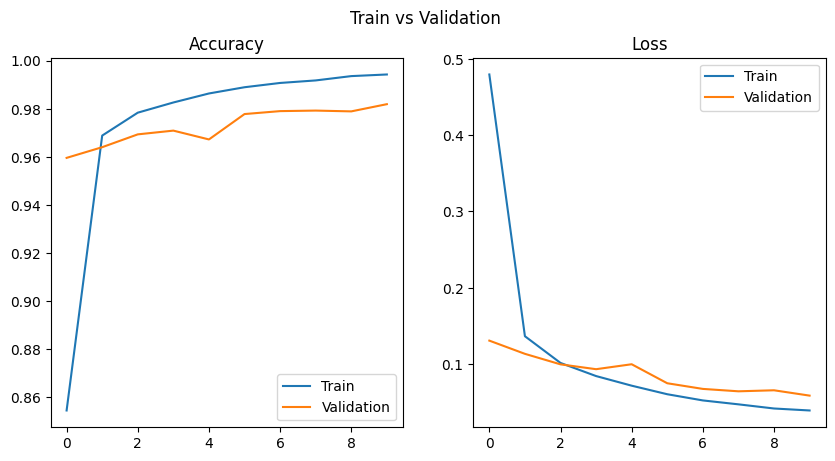

In [12]:
# 1st step: Training model net
t_0 = time.time()
best_vloss = 1_000_000.
n_show_loss = (len(Dl_tar_training_set)//10)
training_logs = {"train_loss": [],  "val_loss": [], "train_acc": [], "val_acc": []}
for epoch in range(num_epochs):
    train_loss, train_correct = 0, 0
    print(f'epochs {epoch+1:04d} / {num_epochs:04d}', end='\n============\n')

    for i, data in enumerate(Dl_tar_training_set):
    # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):
        model.train()
        # zero parameters gradient to Net and optimizer
        # model.zero_grad()
        optimizer.zero_grad()

        # GPU processing source and target data
        x_T, y_T = data[0].to(device), data[1].to(device)

        y_out = model(x_T)
        loss = loss_fn(y_out, y_T) # source classification loss

        # back-propagation (reversed grad to maximize domain loss)
        loss.backward()
        # optimization tuning
        optimizer.step()

        # #output predict from net
        model.eval()
        with torch.no_grad():
          class_prediction = model(x_T)

        if (i+1) % n_show_loss == 0 or i+1 == len(Dl_tar_training_set):
            print(f'[{i+1}/{len(Dl_tar_training_set)}] '
                f'student class loss: {loss.item():.4f} '
                )

        train_loss += loss.item()
        train_correct += (class_prediction.argmax(1) == y_T).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(Dl_tar_training_set))
    training_logs["train_acc"].append(train_correct / len(Dl_tar_training_set.dataset))#.dataset))

    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(Dl_tar_testing_set):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save testing logs
        training_logs["val_loss"].append(valid_loss / len(Dl_tar_testing_set))
        training_logs["val_acc"].append(valid_correct / len(Dl_tar_testing_set.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['val_loss'][-1]:.5f}",
            f"validate acc {training_logs['val_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        path_save_cp = './cp/'
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+save_name)

t_end = time.time()-t_0
print(f"Time consumption for student net (device:{device}): {t_end} sec")
plot_graph(training_logs)

In [13]:
# # Base f32 model, optimizer and cost function
# model = VGG16().to(device)
# save_name = 'best_normal_student_model.pth'
model = VGG16_ptsq().to(device)
save_name = 'best_unquan_student_model.pth'

optimizer = optim.Adam(model.parameters(), lr)
# optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()

epochs 0001 / 0010
[184/1844] student class loss: 0.9034 
[368/1844] student class loss: 0.2114 
[552/1844] student class loss: 0.3057 
[736/1844] student class loss: 0.1254 
[920/1844] student class loss: 0.1083 
[1104/1844] student class loss: 0.2450 
[1288/1844] student class loss: 0.2288 
[1472/1844] student class loss: 0.2194 
[1656/1844] student class loss: 0.2235 
[1840/1844] student class loss: 0.1575 
[1844/1844] student class loss: 0.1118 
Epochs 1   train loss 0.42695 train acc 0.87300 validate loss 0.12756 validate acc 0.95912
--------------------------------------------------------------------------------
epochs 0002 / 0010
[184/1844] student class loss: 0.2944 
[368/1844] student class loss: 0.0763 
[552/1844] student class loss: 0.1940 
[736/1844] student class loss: 0.0095 
[920/1844] student class loss: 0.3411 
[1104/1844] student class loss: 0.0840 
[1288/1844] student class loss: 0.1889 
[1472/1844] student class loss: 0.1872 
[1656/1844] student class loss: 0.0434 


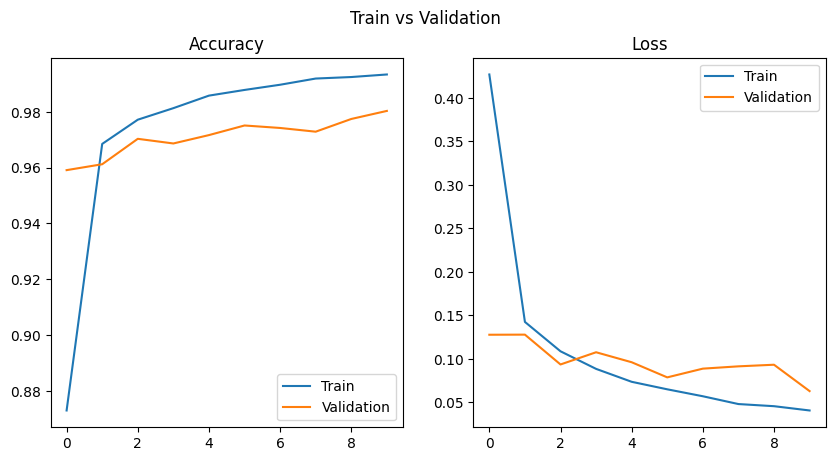

In [14]:
# 1st step: Training model net
t_0 = time.time()
best_vloss = 1_000_000.
n_show_loss = (len(Dl_tar_training_set)//10)
training_logs = {"train_loss": [],  "val_loss": [], "train_acc": [], "val_acc": []}
for epoch in range(num_epochs):
    train_loss, train_correct = 0, 0
    print(f'epochs {epoch+1:04d} / {num_epochs:04d}', end='\n============\n')

    for i, data in enumerate(Dl_tar_training_set):
    # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):
        model.train()
        # zero parameters gradient to Net and optimizer
        # model.zero_grad()
        optimizer.zero_grad()

        # GPU processing source and target data
        x_T, y_T = data[0].to(device), data[1].to(device)

        y_out = model(x_T)
        loss = loss_fn(y_out, y_T) # source classification loss

        # back-propagation (reversed grad to maximize domain loss)
        loss.backward()
        # optimization tuning
        optimizer.step()

        # #output predict from net
        model.eval()
        with torch.no_grad():
          class_prediction = model(x_T)

        if (i+1) % n_show_loss == 0 or i+1 == len(Dl_tar_training_set):
            print(f'[{i+1}/{len(Dl_tar_training_set)}] '
                f'student class loss: {loss.item():.4f} '
                )

        train_loss += loss.item()
        train_correct += (class_prediction.argmax(1) == y_T).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(Dl_tar_training_set))
    training_logs["train_acc"].append(train_correct / len(Dl_tar_training_set.dataset))#.dataset))

    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(Dl_tar_testing_set):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save testing logs
        training_logs["val_loss"].append(valid_loss / len(Dl_tar_testing_set))
        training_logs["val_acc"].append(valid_correct / len(Dl_tar_testing_set.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['val_loss'][-1]:.5f}",
            f"validate acc {training_logs['val_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        path_save_cp = './cp/'
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+save_name)

t_end = time.time()-t_0
print(f"Time consumption for student net (device:{device}): {t_end} sec")
plot_graph(training_logs)

In [15]:
# model_fp32 evaluation
# model instance

model = VGG16()
model.load_state_dict(torch.load('./cp/best_normal_student_model.pth'))
# model = VGG16_ptsq()
# model.load_state_dict(torch.load('./cp/best_unquan_student_model.pth'))

# inferencing
valid_loss, valid_correct = 0, 0
model.to(device).eval()
stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32).to(device)
with torch.no_grad():
    for i, vdata in enumerate(Dl_tar_testing_set):
        vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        valid_loss += loss_fn(voutputs, vlabels).item()
        _, preds_v = torch.max(voutputs, 1)
        valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()

        stored_lbs = torch.cat((stored_lbs, vlabels), 0)
        stored_preds = torch.cat((stored_preds, preds_v), 0)

# save testing logs
print(f'test loss [Normal]: {valid_loss / len(Dl_tar_testing_set):.5f} '
        f'test acc [Normal]: {valid_correct / len(Dl_tar_testing_set.dataset):.5f}')
# print(f'test loss [PTDQ-int8-based]: {valid_loss / len(Dl_tar_testing_set):.5f}'
#         f'\ntest acc [PTDQ-int8-based]: {valid_correct / len(Dl_tar_testing_set.dataset):.5f}')

# summary(model_ptdq_int8, input_size=(channel_size, image_size, image_size))
# count_model_param_flops(model=model_ptdq_int8.eval(), input_res=28, multiply_adds=True)

/tmp/ipykernel_36/1298937835.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./cp/best_normal_student_model.pth'))


test loss [Normal]: 0.05860 test acc [Normal]: 0.98189


### Post training dynamic quantization

In [16]:
# Post training dynamic quantization (PTDQ)
model_ptdq_fp32 = VGG16()
model_ptdq_fp32.load_state_dict(torch.load('./cp/best_normal_student_model.pth'))
model_ptdq_int8 = torch.ao.quantization.quantize_dynamic(
    model_ptdq_fp32,  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights

# run the model
evaluate(model_ptdq_int8, loss_fn, Dl_tar_testing_set, n_eval_batches=32)

print(f'\nPost Training Dynamic Quantization int8 model: {model_ptdq_int8}')
summary(model_ptdq_int8, (channel_size, image_size, image_size), device='cpu')

count_model_param_flops(model=model_ptdq_int8.eval(), input_res=image_size, multiply_adds=True)

print("\nSize of model after dynamic quantization")
print_size_of_model(model_ptdq_int8)

/tmp/ipykernel_36/3841722193.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ptdq_fp32.load_state_dict(torch.load('./cp/best_normal_student_model.pth'))


................................
Post Training Dynamic Quantization int8 model: VGG16(
  (conv1_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv1_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AdaptiveAvgPool2d(output_size=21)
  )
  (conv2_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AdaptiveAvgPool2d(output_

In [17]:
# model_ptdq_int8 evaluation
# model instance
model = model_ptdq_int8

# inferencing
valid_loss, valid_correct = 0, 0
model.cpu().eval()
stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32).cpu()
with torch.no_grad():
    for i, vdata in enumerate(Dl_tar_testing_set):
        vinputs, vlabels = vdata[0].cpu(), vdata[1].cpu()
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        valid_loss += loss_fn(voutputs, vlabels).item()
        _, preds_v = torch.max(voutputs, 1)
        valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()

        stored_lbs = torch.cat((stored_lbs, vlabels), 0)
        stored_preds = torch.cat((stored_preds, preds_v), 0)

# save testing logs
print(f'test loss [PTDQ-int8-based]: {valid_loss / len(Dl_tar_testing_set):.5f} '
        f'test acc [PTDQ-int8-based]: {valid_correct / len(Dl_tar_testing_set.dataset):.5f}')

# summary(model_ptdq_int8, input_size=(channel_size, image_size, image_size))
# count_model_param_flops(model=model_ptdq_int8.eval(), input_res=28, multiply_adds=True)

test loss [PTDQ-int8-based]: 0.05854 test acc [PTDQ-int8-based]: 0.98156


### Post training static quantization

In [18]:
# Post training static quantization (PTSQ)
# define a floating point model where some layers could be statically quantized
import torch.ao.quantization

# create a model instance
model_fp32_ptsq = VGG16_ptsq()
model_fp32_ptsq.load_state_dict(torch.load('./cp/best_unquan_student_model.pth',))
model_fp32_ptsq.to('cpu')

print('VGG16 Conv: Before fusion \n\n', model_fp32_ptsq.conv1_1)

# model must be set to eval mode for static quantization logic to work
model_fp32_ptsq.eval()

# attach a global qconfig, which contains information about what kind
# of observers to attach. Use 'x86' for server inference and 'qnnpack'
# for mobile inference. Other quantization configurations such as selecting
# symmetric or asymmetric quantization and MinMax or L2Norm calibration techniques
# can be specified here.
# Note: the old 'fbgemm' is still available but 'x86' is the recommended default
# for server inference.
# model_fp32_ptsq.qconfig = torch.ao.quantization.get_default_qconfig('fbgemm')
model_fp32_ptsq.qconfig = torch.ao.quantization.get_default_qconfig('x86')
# model_fp32_ptsq.qconfig = torch.ao.quantization.get_default_qconfig('qnnpack')

# Fuse the activations to preceding layers, where applicable.
# This needs to be done manually depending on the model architecture.
# Common fusions include `conv + relu` and `conv + batchnorm + relu`

# print(getattr(model_fp32_ptsq, 'conv1_1'))
modules = [['conv1_1', 'bn1_1', 'relu1_1'], ['conv1_2', 'bn1_2', 'relu1_2'],
           ['conv2_1', 'bn2_1', 'relu2_1'], ['conv2_2', 'bn2_2', 'relu2_2'],
           ['conv3_1', 'bn3_1', 'relu3_1'], ['conv3_2', 'bn3_2', 'relu3_2'], ['conv3_3', 'bn3_3', 'relu3_3'],
           ['conv4_1', 'bn4_1', 'relu4_1'], ['conv4_2', 'bn4_2', 'relu4_2'], ['conv4_3', 'bn4_3', 'relu4_3'],
           ['conv5_1', 'bn5_1', 'relu5_1'], ['conv5_2', 'bn5_2', 'relu5_2'], ['conv5_3', 'bn5_3', 'relu5_3'],
           ['fc1', 'relu_fc1'], ['fc2', 'relu_fc2']]
model_fp32_ptsq_fused = torch.ao.quantization.fuse_modules(model_fp32_ptsq, modules)
print('\nVGG16 Conv: After fusion \n\n', model_fp32_ptsq_fused.conv1_1)

# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
model_fp32_ptsq_prepared = torch.ao.quantization.prepare(model_fp32_ptsq_fused)
print('\nPost Training Quantization Prepare: Inserting Observers')
print('\nConv Block:After observer insertion \n\n', model_fp32_ptsq_prepared.conv1_1)

# calibrate the prepared model to determine quantization parameters for activations
# in a real world setting, the calibration would be done with a representative dataset
evaluate(model_fp32_ptsq_prepared, loss_fn, Dl_tar_testing_set, n_eval_batches=32)
print('\nPost Training Quantization: Calibration done')

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, and replaces key operators with quantized
# implementations.
model_ptsq_int8 = torch.ao.quantization.convert(model_fp32_ptsq_prepared)
print('Post Training Quantization: Convert done')
print(f'Post Training Static Quantization int8 model: {model_ptsq_int8}')

# Print the total number of parameters directly (no need for .numpy() anymore)
total_params = sum(p.numel() for p in model_ptsq_int8.parameters())
print("\n\n\nTotal parameters of Post Training Static Quantization (i.e., PTSQ):", total_params)
count_model_param_flops(model=model_ptsq_int8.eval(), input_res=image_size, multiply_adds=True)

print("Size of model after static quantization")
print_size_of_model(model_ptsq_int8)
summary(model_ptsq_int8, (channel_size, image_size, image_size)) # summary use numpy which have became int8

/tmp/ipykernel_36/3226089798.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_fp32_ptsq.load_state_dict(torch.load('./cp/best_unquan_student_model.pth',))


VGG16 Conv: Before fusion 

 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

VGG16 Conv: After fusion 

 ConvReLU2d(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
)

Post Training Quantization Prepare: Inserting Observers

Conv Block:After observer insertion 

 ConvReLU2d(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
)


/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:221: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


................................
Post Training Quantization: Calibration done
Post Training Quantization: Convert done
Post Training Static Quantization int8 model: VGG16_ptsq(
  (quant): Quantize(scale=tensor([0.0157]), zero_point=tensor([64]), dtype=torch.quint8)
  (conv1_1): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.0691211149096489, zero_point=0, padding=(1, 1))
  (bn1_1): Identity()
  (relu1_1): Identity()
  (conv1_2): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.0784268006682396, zero_point=0, padding=(1, 1))
  (bn1_2): Identity()
  (relu1_2): Identity()
  (avgpool1): AdaptiveAvgPool2d(output_size=21)
  (conv2_1): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.09623528271913528, zero_point=0, padding=(1, 1))
  (bn2_1): Identity()
  (relu2_1): Identity()
  (conv2_2): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.09945190697908401, zero_point=0, padding=(1, 1))
  (bn2_2): Ident

In [19]:
# model_ptsq_int8 evaluation
# model instance
model = model_ptsq_int8

# inferencing
valid_loss, valid_correct = 0, 0
model.cpu().eval()
stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32).cpu()
with torch.no_grad():
    for i, vdata in enumerate(Dl_tar_testing_set):
        vinputs, vlabels = vdata[0].cpu(), vdata[1].cpu()
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        valid_loss += loss_fn(voutputs, vlabels).item()
        _, preds_v = torch.max(voutputs, 1)
        valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()

        stored_lbs = torch.cat((stored_lbs, vlabels), 0)
        stored_preds = torch.cat((stored_preds, preds_v), 0)

# save testing logs
print(f'test loss [PTSQ-int8-based]: {valid_loss / len(Dl_tar_testing_set):.5f} '
        f'test acc [PTSQ-int8-based]: {valid_correct / len(Dl_tar_testing_set.dataset):.5f}')

# summary(model_ptsq_int8, input_size=(channel_size, image_size, image_size))
# count_model_param_flops(model=model_ptsq_int8.eval(), input_res=28, multiply_adds=True)

test loss [PTSQ-int8-based]: 0.06420 test acc [PTSQ-int8-based]: 0.98078


### Quantization-aware training

In [12]:
# QAT:= PTSQ + FT (model_qat_32 --> model_qat_int8)

model_qat_fp32 = VGG16_ptsq()  # create a new model instance
model_qat_fp32.load_state_dict(torch.load('./cp/best_unquan_student_model.pth'))  # load cp to model
# model must be set to eval mode for static quantization logic to work
model_qat_fp32.to('cpu').eval()

#########################################################################
# fused FP32 model preparation
# attach a global qconfig, which contains information about what kind
# of observers to attach. Use 'x86' for server inference and 'qnnpack'
# for mobile inference. Other quantization configurations such as selecting
# symmetric or asymmetric quantization and MinMax or L2Norm calibration techniques
# can be specified here.
# Note: the old 'fbgemm' is still available but 'x86' is the recommended default
# for server inference.
# model_ptsq_fp32.qconfig = torch.ao.quantization.get_default_qconfig('fbgemm')
model_qat_fp32.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
# model_qat_fp32.qconfig = torch.ao.quantization.get_default_qconfig('qnnpack')

# Fuse the activations to preceding layers, where applicable.
# This needs to be done manually depending on the model architecture.
# Common fusions include `conv + relu` and `conv + batchnorm + relu`
modules = [['conv1_1', 'bn1_1', 'relu1_1'], ['conv1_2', 'bn1_2', 'relu1_2'],
           ['conv2_1', 'bn2_1', 'relu2_1'], ['conv2_2', 'bn2_2', 'relu2_2'],
           ['conv3_1', 'bn3_1', 'relu3_1'], ['conv3_2', 'bn3_2', 'relu3_2'], ['conv3_3', 'bn3_3', 'relu3_3'],
           ['conv4_1', 'bn4_1', 'relu4_1'], ['conv4_2', 'bn4_2', 'relu4_2'], ['conv4_3', 'bn4_3', 'relu4_3'],
           ['conv5_1', 'bn5_1', 'relu5_1'], ['conv5_2', 'bn5_2', 'relu5_2'], ['conv5_3', 'bn5_3', 'relu5_3'],
           ['fc1', 'relu_fc1'], ['fc2', 'relu_fc2']]
model_qat_fp32_fused = torch.ao.quantization.fuse_modules_qat(model_qat_fp32, modules)
print('\nVGG16 Conv: After fusion \n\n', model_qat_fp32_fused.conv1_1)

# Prepare the model for QAT. This inserts observers and fake_quants in
# the model needs to be set to train for QAT logic to work
# the model that will observe weight and activation tensors during calibration.
model_qat_fp32_prepared = torch.ao.quantization.prepare_qat(model_qat_fp32_fused.train())
print('\nPost Training Quantization Prepare: Fake-quantization modules')
print('\nConv Block: After preparation for QAT \n\n', model_qat_fp32_prepared.conv1_1)

print("All layers in Fake Quant FP32 model for Fine-tuning: ", model_qat_fp32_prepared)
# print("All parameter lists in Fake Quant FP32 model for Fine-tuning: ")
# print([(name, module) for name, module in model_qat_fp32_prepared.named_modules()])

/tmp/ipykernel_37/2561526140.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_qat_fp32.load_state_dict(torch.load('./cp/best_unquan_student_model.pth'))  # load cp 

FileNotFoundError: [Errno 2] No such file or directory: './cp/best_unquan_student_model.pth'

epochs 0001 / 0010
[184/1844] student class loss: 0.0147 
[368/1844] student class loss: 0.0019 
[552/1844] student class loss: 0.0011 
[736/1844] student class loss: 0.0015 
[920/1844] student class loss: 0.0023 
[1104/1844] student class loss: 0.0100 
[1288/1844] student class loss: 0.1480 
[1472/1844] student class loss: 0.0049 
[1656/1844] student class loss: 0.0017 
[1840/1844] student class loss: 0.0174 
[1844/1844] student class loss: 0.0005 
Epochs 1   train loss 0.02056 train acc 0.99544 validate loss 0.06368 validate acc 0.98411
--------------------------------------------------------------------------------
epochs 0002 / 0010
[184/1844] student class loss: 0.0103 
[368/1844] student class loss: 0.0005 
[552/1844] student class loss: 0.0070 
[736/1844] student class loss: 0.0001 
[920/1844] student class loss: 0.0000 
[1104/1844] student class loss: 0.0000 
[1288/1844] student class loss: 0.0004 
[1472/1844] student class loss: 0.0002 
[1656/1844] student class loss: 0.0011 


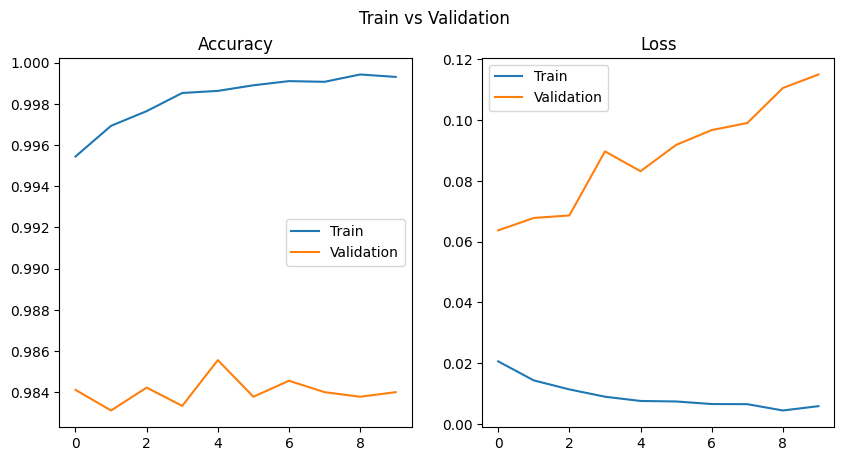

In [21]:
# Fine-tuning to fake (in-preparation) quant FP32 model
# batch training for QAT

# 1st-option: Declare optimizer and some layer tuned
# optimizer = optim.Adam(model_qat_fp32_prepared.parameters(), lr=1e-6)
# # Set requires_grad to False for all parameters
# for param in model_qat_fp32_prepared.parameters():
#     param.requires_grad = False
# # Set requires_grad to True for the parameters you want to fine-tune
# for name, param in model_qat_fp32_prepared.named_parameters():
#     print("Name: ", name)
#     if 'linear_1' in name or 'linear_2' in name:
#         param.requires_grad = True
# 2nd-option: define learning rate in each layer
optimizer = optim.Adam(
    [dict(params=model_qat_fp32_prepared.conv1_1.parameters(), lr=0),
      dict(params=model_qat_fp32_prepared.conv1_2.parameters(), lr=0),
      dict(params=model_qat_fp32_prepared.conv2_1.parameters(), lr=0),
      dict(params=model_qat_fp32_prepared.conv2_2.parameters(), lr=0),
      dict(params=model_qat_fp32_prepared.conv3_1.parameters(), lr=1e-6),
      dict(params=model_qat_fp32_prepared.conv3_2.parameters(), lr=1e-6),
      dict(params=model_qat_fp32_prepared.conv3_3.parameters(), lr=1e-6),
      dict(params=model_qat_fp32_prepared.conv4_1.parameters(), lr=5e-6),
      dict(params=model_qat_fp32_prepared.conv4_2.parameters(), lr=5e-6),
      dict(params=model_qat_fp32_prepared.conv4_3.parameters(), lr=5e-6),
      dict(params=model_qat_fp32_prepared.conv5_1.parameters(), lr=1e-5),
      dict(params=model_qat_fp32_prepared.conv5_2.parameters(), lr=1e-5),
      dict(params=model_qat_fp32_prepared.conv5_3.parameters(), lr=1e-5),
      dict(params=model_qat_fp32_prepared.fc1.parameters(), lr=5e-5),
      dict(params=model_qat_fp32_prepared.fc2.parameters(), lr=5e-5),
      dict(params=model_qat_fp32_prepared.fc3.parameters(), lr=1e-4),
      ],
    # lr=lr,
)
loss_fn = torch.nn.CrossEntropyLoss()


t_0 = time.time()
best_vloss = 1_000_000.
n_show_loss = (len(Dl_tar_training_set)//10)
training_logs = {"train_loss": [],  "val_loss": [], "train_acc": [], "val_acc": []}
n_epochs_ft_ptsq = 10
for epoch in range(n_epochs_ft_ptsq):
    model_qat_fp32_prepared.to(device)
    train_loss, train_correct = 0, 0
    print(f'epochs {epoch+1:04d} / {num_epochs:04d}', end='\n============\n')
    for i, data in enumerate(Dl_tar_training_set):
        model_qat_fp32_prepared.train()

        optimizer.zero_grad()
        x_T, y_T = data[0].to(device), data[1].to(device)
        y_out = model_qat_fp32_prepared(x_T)
        loss = loss_fn(y_out, y_T)

        loss.backward()
        optimizer.step()
        model_qat_fp32_prepared.eval()
        with torch.no_grad():
          class_prediction = model_qat_fp32_prepared(x_T)

        if (i+1) % n_show_loss == 0 or i+1 == len(Dl_tar_training_set):
            print(f'[{i+1}/{len(Dl_tar_training_set)}] '
                f'student class loss: {loss.item():.4f} '
                )

        train_loss += loss.item()
        train_correct += (class_prediction.argmax(1) == y_T).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(Dl_tar_training_set))
    training_logs["train_acc"].append(train_correct / len(Dl_tar_training_set.dataset))

    model_qat_fp32_prepared.eval()
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(Dl_tar_testing_set):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model_qat_fp32_prepared(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save testing logs
        training_logs["val_loss"].append(valid_loss / len(Dl_tar_testing_set))
        training_logs["val_acc"].append(valid_correct / len(Dl_tar_testing_set.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['val_loss'][-1]:.5f}",
            f"validate acc {training_logs['val_acc'][-1]:.5f}",
            )
        print("-"*80)

    if valid_loss < best_vloss:
        best_vloss = valid_loss
        path_save_cp = './cp/'
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        model_qat_fp32_prepared.cpu().eval()
        model_qat_best = torch.ao.quantization.convert(model_qat_fp32_prepared)
        torch.save(model_qat_best.state_dict(), path_save_cp+"best_qat_model.pth")

t_end = time.time()-t_0
print(f"Time consumption for fake quantization (device:{device}): {t_end} sec")
plot_graph(training_logs)

In [22]:
# Quanted FP32 model --> convert ---> Quanted INT8 model + Evaluation

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, and replaces key operators with quantized
# implementations.
model_qat_fp32_prepared.cpu().eval()
model_qat_int8 = torch.ao.quantization.convert(model_qat_fp32_prepared)
print('Quantization-Aware: Convert done')
print(f'Quantization-Aware Training int8 model: {model_qat_int8}')

# run the model, relevant calculations will happen in int8
# input_fp32 = torch.randn(1, 3, 28, 28)
# res = model_qat_int8(input_fp32)
# print(f'tensor predicted: {res} || dtype: {res.dtype}')

#---Fine-Tuning
# print("All parameter lists in INT8 model: ", model_qat_int8.named_parameters())

# # Check if there are parameters that require gradients
# for name, param in model_qat_int8.named_parameters():
#   print(f'Parameter name: {name} | Requires gradient: {param.requires_grad}')
# # Set requires_grad to True for the parameters you want to fine-tune
for param in model_qat_int8.parameters():
    param.requires_grad = True

# Print the total number of parameters directly (no need for .numpy() anymore)
total_params = sum(p.numel() for p in model_qat_int8.parameters())
print("\n\n\nTotal parameters of Quantization-Aware Training (QAT)):", total_params)
count_model_param_flops(model=model_qat_int8.eval(), input_res=image_size, multiply_adds=True)

print("Size of model after quantization aware")
print_size_of_model(model_qat_int8)
# summary(model, input_size=(channel_size, image_size, image_size))

Quantization-Aware: Convert done
Quantization-Aware Training int8 model: VGG16_ptsq(
  (quant): Quantize(scale=tensor([0.0157]), zero_point=tensor([64]), dtype=torch.quint8)
  (conv1_1): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.07454541325569153, zero_point=0, padding=(1, 1))
  (bn1_1): Identity()
  (relu1_1): Identity()
  (conv1_2): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.07688934355974197, zero_point=0, padding=(1, 1))
  (bn1_2): Identity()
  (relu1_2): Identity()
  (avgpool1): AdaptiveAvgPool2d(output_size=21)
  (conv2_1): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.08486255258321762, zero_point=0, padding=(1, 1))
  (bn2_1): Identity()
  (relu2_1): Identity()
  (conv2_2): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.08529070764780045, zero_point=0, padding=(1, 1))
  (bn2_2): Identity()
  (relu2_2): Identity()
  (avgpool2): AdaptiveAvgPool2d(output_size=16)
  (conv3_1):

In [23]:
model = model_qat_int8
# model = torch.load('./cp/best_qat_model.pth')

# inferencing
valid_loss, valid_correct = 0, 0
model.cpu().eval()
stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32).cpu()
with torch.no_grad():
    for i, vdata in enumerate(Dl_tar_testing_set):
        vinputs, vlabels = vdata[0].cpu(), vdata[1].cpu()
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        valid_loss += loss_fn(voutputs, vlabels).item()
        _, preds_v = torch.max(voutputs, 1)
        valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()

        stored_lbs = torch.cat((stored_lbs, vlabels), 0)
        stored_preds = torch.cat((stored_preds, preds_v), 0)

  # save testing logs
print(f'test loss [QAT-int8-based student]: {valid_loss / len(Dl_tar_testing_set):.5f}'
    f'test acc [QAT-int8-based student]: {valid_correct / len(Dl_tar_testing_set.dataset):.5f}')

test loss [QAT-int8-based student]: 0.12017test acc [QAT-int8-based student]: 0.98400


In [24]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    Normalization can be applied by setting `normalize=True`.
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)    #office-31
    plt.xticks(tick_marks, classes, rotation=20, fontsize=12)    #office-home
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize==True:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+1)
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    # print(cm)

    formated = '.2f' if normalize==True else 'd'
    #---manual---
    thresh = cm.max() / 2.
    #thresh > 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], formated),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #---sns---
    #df_cm = pd.DataFrame(cm, classes, classes)
    #sns.heatmap(df_cm, annot=True, fmt=formated, cmap=cmap)

    plt.gcf().set_size_inches(8, 6)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.margins(2,2)
    plt.tight_layout()



"""
  Args: Collect feature
  Ref: https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/__init__.py#L7
"""
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import tqdm
import os.path as osp


def collect_feature(data_loader: DataLoader, feature_extractor: nn.Module,
                                   device: torch.device, max_num_features=None) -> torch.Tensor:
    """
    Fetch data from `data_loader`, and then use `feature_extractor` to collect features
    Args:
        data_loader (torch.utils.data.DataLoader): Data loader.
        feature_extractor (torch.nn.Module): A feature extractor.
        device (torch.device)
        max_num_features (int): The max number of features to return
    Returns:
        Features in shape (min(len(data_loader), max_num_features), :math:`|\mathcal{F}|`).
    """
    feature_extractor.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
            images = images.to(device)
            features = feature_extractor(images)
            if isinstance(features, tuple):
                # Check if it's a tuple (common when using certain pre-trained models)
                # You may want to select the feature tensor you need from the tuple
                # For example, if the feature tensor is the first element of the tuple:
                feature_tensor = features[0]
                feature_tensor = feature_tensor.to(device)  # Move the tensor to CPU
            else:
                feature_tensor = features.to(device)  # Move the tensor to CPU

            all_features.append(feature_tensor)
            all_labels.append(target)

    return torch.cat(all_features, dim=0),\
        torch.cat(all_labels, dim=0) # Concatenate the list of feature tensors

    #        all_features.append(features)
    #        if max_num_features is not None and i >= max_num_features:
    #            break
    #return torch.cat(all_features, dim=0)


Precision/Recall/F-beta score: (0.9840291467606426, 0.9840017775802689, 0.9839916031207223, None)
NMI score: 0.9548206002220413, RI score: 0.9649101951502312


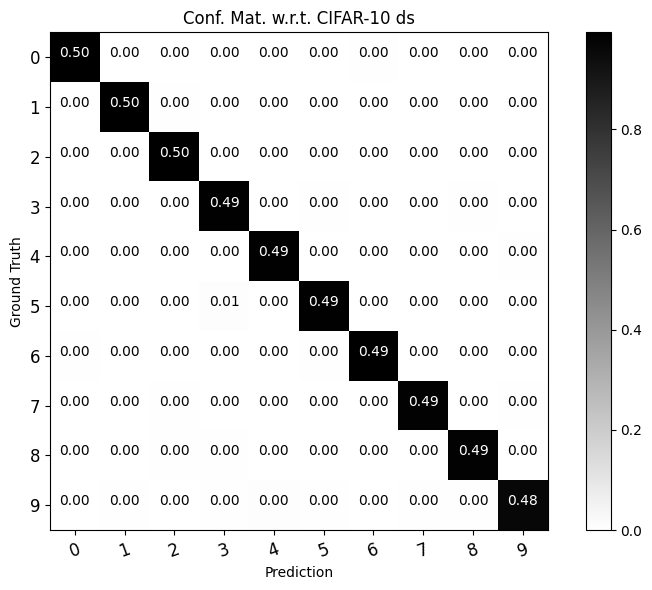

In [26]:
loaded_model = model.cpu()
# source_feature, s_labels = collect_feature(Dl_tar_testing_set, loaded_model, torch.device('cpu'))
# target_feature, t_labels = collect_feature(target_dl, feature_extractor, device)

# --- Confusion matrix, F1-score, precision, recall, NMI/RI scores
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, normalized_mutual_info_score, adjusted_rand_score#, f1_score
# Class labels
pos_labels = np.arange(10)
lb_classes = ('0', '1', '2', '3', '4', '5', '6' ,'7', '8', '9')
# pos_labels = np.arange(100)
# lb_classes = (str(i) for i in range(0,100))

lb = stored_lbs.cpu()
prd = stored_preds.cpu()
#---confusion matrix
cm_target = confusion_matrix(y_true=lb,
                            y_pred=prd,
                            labels=pos_labels,
                            normalize='true',
                            )
plt.figure()
plt.rcParams.update({'font.size': 10, 'figure.figsize': (2,2)})
plot_confusion_matrix(cm_target,
                        classes=lb_classes,
                        normalize=True,
                        title='Conf. Mat. w.r.t. CIFAR-10 ds',
                        cmap=plt.cm.binary #Blues_r
                        )    #Blues_r = off-white diagonal
#---F1-score/Precision/Recall scores
print("Precision/Recall/F-beta score:", precision_recall_fscore_support(lb, prd, average='weighted', zero_division=0,
                                          beta=1.0)) #labels=label_classes))
#---Normalized Mutual Information (NMI) score
nmi_score = normalized_mutual_info_score(labels_true=lb,
                                        labels_pred=prd,
                                        average_method='arithmetic',
                                        )
#---Rand Index (RI) score
ri_score = adjusted_rand_score(labels_true=lb,
                                labels_pred=prd,
                                )
print(f"NMI score: {nmi_score}, RI score: {ri_score}")